<a href="https://colab.research.google.com/github/iBalag/games-with-nn/blob/master/Emotion_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import torch
import os
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import StepLR

In [0]:
legend_df = pd.read_csv("/gdrive/My Drive/data/facial_expressions/legend.csv")

In [0]:
!rm -r /content/data
!mkdir /content/data
!unzip /gdrive/My\ Drive/data/facial_expressions/train.zip -d /content/data

In [5]:
labels_df = legend_df["emotion"].unique()
labels_list = labels_df.tolist()
labels = dict(zip(labels_list, range(len(labels_list))))
print(labels)

{'anger': 0, 'surprise': 1, 'disgust': 2, 'fear': 3, 'neutral': 4, 'happiness': 5, 'sadness': 6, 'contempt': 7}


In [0]:
class FacialExpressionDataset(Dataset):
    def __init__(self, root_folder, legend, labels, transform=None):
        self.transform = transform
        self.root_folder = root_folder
        self.legend = legend
        self.labels = labels
    
    def __len__(self):
        return self.legend.shape[0]
    
    def __getitem__(self, index):
        image_entity = self.legend.iloc[index]
        label = image_entity["emotion"]
        label_id = self.labels[label]
        image_name = image_entity["image"]
        image_path = os.path.join(self.root_folder, image_name)
        
        img = Image.open(image_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
            
        return img, label_id, image_name

In [0]:
# root_folder = "/content/data/images"
# orig_dataset = FacialExpressionDataset(root_folder, legend_df, labels, transform=transforms.Compose([transforms.ToTensor()]))
# loader = torch.utils.data.DataLoader(orig_dataset, batch_size=1, num_workers=2, shuffle=False)

# height = []
# width = []

# for image, lable in loader:
#     width.append(image.size(2))
#     height.append(image.size(3))

In [0]:
# print(f"h min: {min(height)}; h max: {max(height)}; h mean: {np.mean(height)}")
# print(f"w min: {min(width)}; w max: {max(width)}; w mean: {np.mean(width)}")

In [0]:
# df_size = pd.DataFrame({"width" : width, "height": height})

In [0]:
# df_size["width"].plot.hist()

In [0]:
# df_size["height"].plot.hist()

In [0]:
# root_folder = "/content/data/images"
# orig_dataset = FacialExpressionDataset(root_folder, legend_df, labels, 
#                                        transform=transforms.Compose(
#                                            [
#                                                transforms.transforms.Resize((224, 224)),
#                                                transforms.ToTensor()
#                                            ]))

# loader = torch.utils.data.DataLoader(orig_dataset, batch_size=10, num_workers=1, shuffle=False)

# mean = 0.
# std = 0.

# for image, lable, img_name in loader:
#     batch_samples = image.size(0) # batch size (the last batch can have smaller size!)
#     image = image.view(batch_samples, image.size(1), -1)
#     mean += image.mean(2).sum(0)
#     std += image.std(2).sum(0)

# mean /= len(loader.dataset)
# std /= len(loader.dataset)

# print(f"mean: {mean}")
# print(f"std: {std}")

In [0]:
root_folder = "/content/data/images"
train_dataset = FacialExpressionDataset(root_folder, legend_df, labels,
                                       transform=transforms.Compose(
                                           [
                                               transforms.transforms.Resize((224, 224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.4739, 0.4663, 0.4636], std=[0.1864, 0.1849, 0.1844])      
                                           ]))

data_size = legend_df.shape[0]
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)


val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=val_sampler)

In [0]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [0]:
n_classes = len(labels)

nn_model_cnn = nn.Sequential(
            # input 3x224x224
            nn.Conv2d(3, 32, 5),
            # output (224-5)+1 = 220 
            nn.ReLU(inplace=True),            
            nn.MaxPool2d(2),
            # output (220 - (2-1))/2 = 109
            nn.Conv2d(32, 64, 4),
            # output (109-4)+1 = 106
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            # (106 - (4-1))/4 = 25.75
            # output 26 ?
            Flattener(),
            nn.Linear(64*26*26, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_classes)
         )

nn_model_cnn.type(torch.cuda.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(nn_model_cnn.parameters(), lr=1e-4, weight_decay=1e-1)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

device = torch.device("cuda:0")

In [0]:
def train_model_cnn(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()
        print('Epoch:', epoch,'LR:', scheduler.get_lr())
      
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, img) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy_cnn(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy_cnn(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode    
    correct = 0
    total = 0
    for data in val_loader:
        images, labels, img = data
        images_gpu = images.to(device)
        labels_gpu = labels.to(device)
        
        outputs = model(images_gpu)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels_gpu.size(0)
        correct += (predicted == labels_gpu).sum().item()
    
    return correct / total

In [11]:
loss_history, train_history, val_history = train_model_cnn(nn_model_cnn, train_loader, val_loader, loss, optimizer, scheduler, 5)

Epoch: 0 LR: [0.0001]
Average loss: 1.498900, Train accuracy: 0.719047, Val accuracy: 0.711103
Epoch: 1 LR: [2.5e-05]
Average loss: 1.171655, Train accuracy: 0.805789, Val accuracy: 0.777575
Epoch: 2 LR: [5e-05]
Average loss: 1.024847, Train accuracy: 0.829438, Val accuracy: 0.791454
Epoch: 3 LR: [1.25e-05]
Average loss: 0.898507, Train accuracy: 0.860939, Val accuracy: 0.788897
Epoch: 4 LR: [2.5e-05]
Average loss: 0.832855, Train accuracy: 0.875913, Val accuracy: 0.817385


In [0]:
def visualize_result(model, dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))    
        
    sampler = SubsetRandomSampler(display_indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=count, sampler=sampler)
    
    model.eval()
    
    gt_y = []
    pr_y = []
    img_names = []
    
    images = []
    
    for x, y_gt, img_name in loader:          
        images = x
        x_gpu = x.to(device)        
        outputs = model(x_gpu)        
        _, y_predicted = torch.max(outputs.data, 1)
        
        pr_y = y_predicted.tolist()
        gt_y = y_gt.tolist()
        img_names = list(img_name)
        
        
    for i in range(count):         
        y_gt_i = gt_y[i]
        y_predicted_i = pr_y[i]
        image = images[i]
        gt_label = next((label for label, label_id in labels.items() if label_id == y_gt_i), None)
        predict_label = next((label for label, label_id in labels.items() if label_id == y_predicted_i), None)
        
        plt.subplot(1, count, i+1)
        plt.title(f"GT: {gt_label} \ P: {predict_label}")
        
        full_name = os.path.join(dataset.root_folder, img_names[i])
        img = Image.open(full_name)
        
        plt.imshow(img)
        plt.grid(False)
        plt.axis('off')

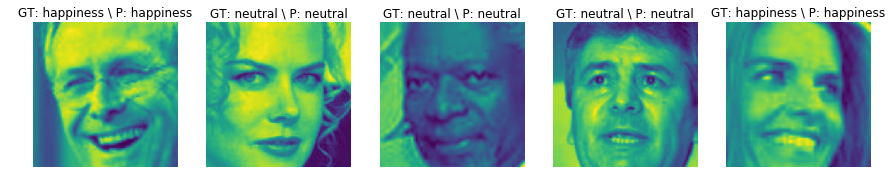

In [13]:
visualize_result(nn_model_cnn, train_dataset, val_indices, count=5)

In [15]:
!rm -r /content/test/
!mkdir /content/test
!unzip /gdrive/My\ Drive/data/facial_expressions/emotions\ \(1\).zip -d /content/test

Archive:  /gdrive/My Drive/data/facial_expressions/emotions (1).zip
  inflating: /content/test/20190712_150351.jpg  
  inflating: /content/test/20190712_150434.jpg  
  inflating: /content/test/20190712_150437.jpg  
  inflating: /content/test/20190712_150441.jpg  
  inflating: /content/test/20190712_150445.jpg  


In [0]:
legend_test_df = pd.read_csv("/gdrive/My Drive/data/facial_expressions/legend_test.csv")

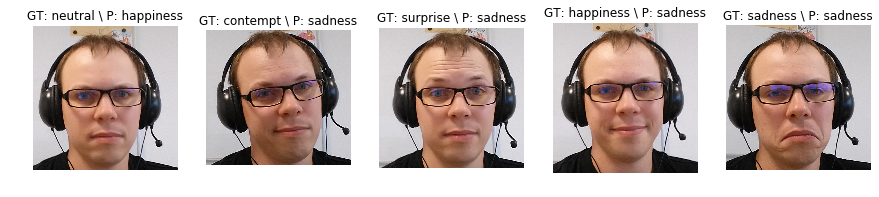

In [19]:
test_dataset = FacialExpressionDataset("/content/test/", legend_test_df, labels,
                                       transform=transforms.Compose(
                                           [
                                               transforms.transforms.Resize((224, 224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.4739, 0.4663, 0.4636], std=[0.1864, 0.1849, 0.1844])      
                                           ]))

visualize_result(nn_model_cnn, test_dataset, range(len(test_dataset)), count=5)